In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Admissions Table and Readmission Calculation**

In [ ]:
PATH = "/content/drive/MyDrive/Spring_AI-in-Health/MIMIC-III/"

In [ ]:
df_adm = pd.read_csv(os.path.join(PATH, "ADMISSIONS.csv"))

In [ ]:
# convert to dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [ ]:
# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)
df_adm.head()

ROW_ID  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0       1           2   163353 2138-07-17 19:04:00 2138-07-21 15:48:00   
1       2           3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
2       3           4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   
3       4           5   178980 2103-02-02 04:31:00 2103-02-04 12:15:00   
4       5           6   107064 2175-05-30 07:15:00 2175-06-15 16:00:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaT        NEWBORN  PHYS REFERRAL/NORMAL DELI   
1       NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
2       NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
3       NaT        NEWBORN  PHYS REFERRAL/NORMAL DELI   
4       NaT       ELECTIVE  PHYS REFERRAL/NORMAL DELI   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0                       HOME   Private      NaN      NOT SPECIFIED   
1                        SNF  Medicare      NaN           CATHOLIC   
2  HOME WITH HOME IV PROVIDR   Private      NaN  PROTESTANT QUAKER   
3                       HOME   Private      NaN           BUDDHIST   
4           HOME HEALTH CARE  Medicare     ENGL      NOT SPECIFIED   

  MARITAL_STATUS ETHNICITY            EDREGTIME            EDOUTTIME  \
0            NaN     ASIAN                  NaN                  NaN   
1        MARRIED     WHITE  2101-10-20 17:09:00  2101-10-20 19:24:00   
2         SINGLE     WHITE  2191-03-15 13:10:00  2191-03-16 01:10:00   
3            NaN     ASIAN                  NaN                  NaN   
4        MARRIED     WHITE                  NaN                  NaN   

                             DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                              NEWBORN                     0   
1                          HYPOTENSION                     0   
2  FEVER,DEHYDRATION,FAILURE TO THRIVE                     0   
3                              NEWBORN                     0   
4            CHRONIC RENAL FAILURE/SDA                     0   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [ ]:
df_adm.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

In [ ]:
# check to see if there are any missing dates
print('Number of missing date admissions:', df_adm.ADMITTIME.isnull().sum())
print('Number of missing date discharges:', df_adm.DISCHTIME.isnull().sum())

Number of missing date admissions: 0
Number of missing date discharges: 0


In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

SUBJECT_ID           ADMITTIME ADMISSION_TYPE
165         124 2160-06-24 21:25:00      EMERGENCY
166         124 2161-12-17 03:39:00      EMERGENCY
167         124 2165-05-21 21:02:00       ELECTIVE
168         124 2165-12-31 18:55:00      EMERGENCY

In [ ]:
# add the next admission date and type for each subject using groupby
# you have to use groupby otherwise the dates will be from different subjects
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

SUBJECT_ID           ADMITTIME ADMISSION_TYPE      NEXT_ADMITTIME  \
165         124 2160-06-24 21:25:00      EMERGENCY 2161-12-17 03:39:00   
166         124 2161-12-17 03:39:00      EMERGENCY 2165-05-21 21:02:00   
167         124 2165-05-21 21:02:00       ELECTIVE 2165-12-31 18:55:00   
168         124 2165-12-31 18:55:00      EMERGENCY                 NaT   

    NEXT_ADMISSION_TYPE  
165           EMERGENCY  
166            ELECTIVE  
167           EMERGENCY  
168                 NaN

In [ ]:
# get rows where next admission is elective and replace with naT or nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

SUBJECT_ID           ADMITTIME ADMISSION_TYPE      NEXT_ADMITTIME  \
165         124 2160-06-24 21:25:00      EMERGENCY 2161-12-17 03:39:00   
166         124 2161-12-17 03:39:00      EMERGENCY                 NaT   
167         124 2165-05-21 21:02:00       ELECTIVE 2165-12-31 18:55:00   
168         124 2165-12-31 18:55:00      EMERGENCY                 NaT   

    NEXT_ADMISSION_TYPE  
165           EMERGENCY  
166                 NaN  
167           EMERGENCY  
168                 NaN

In [ ]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill incase something changed the order above
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])

# back fill (this will take a little while)
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

SUBJECT_ID           ADMITTIME ADMISSION_TYPE      NEXT_ADMITTIME  \
165         124 2160-06-24 21:25:00      EMERGENCY 2161-12-17 03:39:00   
166         124 2161-12-17 03:39:00      EMERGENCY 2165-12-31 18:55:00   
167         124 2165-05-21 21:02:00       ELECTIVE 2165-12-31 18:55:00   
168         124 2165-12-31 18:55:00      EMERGENCY                 NaT   

    NEXT_ADMISSION_TYPE  
165           EMERGENCY  
166           EMERGENCY  
167           EMERGENCY  
168                 NaN

In [ ]:
# calculate the number of days between discharge and next admission
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)

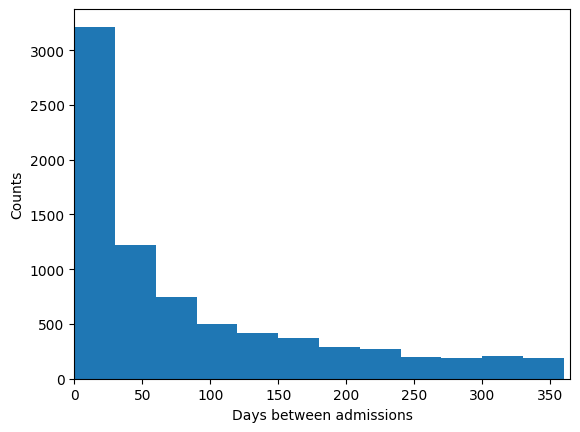

In [ ]:
# plot a histogram of days between readmissions if they exist
# this only works for non-null values so you have to filter
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [ ]:
print('Number with a readmission:', (~df_adm.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total Number:', len(df_adm))

Number with a readmission: 11399
Total Number: 58976


In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','DISCHTIME','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE', 'DAYS_NEXT_ADMIT']]

SUBJECT_ID           ADMITTIME ADMISSION_TYPE           DISCHTIME  \
165         124 2160-06-24 21:25:00      EMERGENCY 2160-07-15 15:10:00   
166         124 2161-12-17 03:39:00      EMERGENCY 2161-12-24 15:35:00   
167         124 2165-05-21 21:02:00       ELECTIVE 2165-06-06 16:00:00   
168         124 2165-12-31 18:55:00      EMERGENCY 2166-02-01 06:55:00   

         NEXT_ADMITTIME NEXT_ADMISSION_TYPE  DAYS_NEXT_ADMIT  
165 2161-12-17 03:39:00           EMERGENCY       519.520139  
166 2165-12-31 18:55:00           EMERGENCY      1468.138889  
167 2165-12-31 18:55:00           EMERGENCY       208.121528  
168                 NaT                 NaN              NaN

In [ ]:
df_adm_archived = df_adm.copy(deep=True)

# **Data Preprocessing**

In [ ]:
# Primary Admissions information
# Add'.gz' if you uploaded .gz file

# Patient specific info such as gender
df_pat = pd.read_csv(os.path.join(PATH, 'PATIENTS.csv'))

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv(os.path.join(PATH, 'DIAGNOSES_ICD.csv'))

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv(os.path.join(PATH, 'ICUSTAYS.csv'))

## Admission dataset

### Race/Ethinicity

In [ ]:
df_adm['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85


In [ ]:
# Compress the number of ethnicity categories
df_adm['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df_adm['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df_adm['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df_adm['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df_adm['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df_adm['ETHNICITY'].loc[~df_adm['ETHNICITY'].isin(df_adm['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df_adm['ETHNICITY'].value_counts()

ETHNICITY
WHITE                     41325
OTHER/UNKNOWN              7731
BLACK/AFRICAN AMERICAN     5785
HISPANIC/LATINO            2128
ASIAN                      2007
Name: count, dtype: int64

### Religion

In [ ]:
df_adm['RELIGION'].value_counts()

RELIGION
CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: count, dtype: int64

Excluded religion from the prediction model

### Health insurance

In [ ]:
df_adm['INSURANCE'].value_counts()

INSURANCE
Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: count, dtype: int64

### Marital status

In [ ]:
df_adm['MARITAL_STATUS'].value_counts(dropna=False)

MARITAL_STATUS
MARRIED              24239
SINGLE               13254
NaN                  10128
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: count, dtype: int64

In [ ]:
# Fix NaNs and file under 'UNKNOWN'
df_adm['MARITAL_STATUS'] = df_adm['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
# Combine WIDOWED/DIVORCED/SEPARATED into one subgroup
df_adm['MARITAL_STATUS'].replace("WIDOWED", "WDS", inplace=True)
df_adm['MARITAL_STATUS'].replace("DIVORCED", "WDS", inplace=True)
df_adm['MARITAL_STATUS'].replace("SEPARATED", "WDS", inplace=True)
# Combine LIFE PARTNER with MARRIED
df_adm['MARITAL_STATUS'].replace("LIFE PARTNER", "MARRIED", inplace=True)
df_adm['MARITAL_STATUS'].value_counts(dropna=False)

MARITAL_STATUS
MARRIED              24254
SINGLE               13254
WDS                  10995
UNKNOWN (DEFAULT)    10473
Name: count, dtype: int64

### Length of stay

In [ ]:
# Convert admission and discharge times to datatime type
df_adm['ADMITTIME'] = pd.to_datetime(df_adm['ADMITTIME'])
df_adm['DISCHTIME'] = pd.to_datetime(df_adm['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
df_adm['LOS'] = (df_adm['DISCHTIME'] - df_adm['ADMITTIME']).dt.total_seconds()/86400

In [ ]:
df_adm[['LOS']].describe()

LOS
count  58976.000000
mean      10.133916
std       12.456682
min       -0.945139
25%        3.743750
50%        6.467014
75%       11.795139
max      294.660417

## Deceased

In [ ]:
# Mark admissions where patients died in boolean column
df_adm['DECEASED'] = df_adm['DEATHTIME'].notnull().map({True:1, False:0})

## Diagnoses dataset

In [ ]:
df_diagcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [ ]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
# df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='-1', inplace=True)

In [ ]:
# https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
# df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [ ]:
df_diagcode.tail()

ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE recode
651042  639798       97503   188195      2.0     20280    202
651043  639799       97503   188195      3.0     V5869    V58
651044  639800       97503   188195      4.0     V1279    V12
651045  639801       97503   188195      5.0      5275    527
651046  639802       97503   188195      6.0      5569    556

In [ ]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000)]

# Associated category names
diag_dict = {
    0: 'infectious',
    1: 'neoplasms',
    2: 'endocrine',
    3: 'blood',
    4: 'mental',
    5: 'nervous',
    6: 'circulatory',
    7: 'respiratory',
    8: 'digestive',
    9: 'genitourinary',
    10: 'pregnancy',
    11: 'skin',
    12: 'muscular',
    13: 'congenital',
    14: 'prenatal',
    15: 'symtoms_signs',
    16: 'injury',
    17: 'supp1',
    18: 'supp2',}

# Re-code in terms of integer
def recode_indexing(s, replacement, cat_range):
  if 'V' in str(s):
    return 17
  elif 'E' in str(s):
    return 18
  else:
    return replacement if (int(s) >= cat_range[0]) and (int(s) < cat_range[1]) else s

for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = df_diagcode['recode'].apply(lambda x: recode_indexing(x, num, cat_range))

# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [ ]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

HADM_ID                                                cat
0   100001  [endocrine, nervous, genitourinary, digestive,...
1   100003  [digestive, blood, infectious, digestive, circ...
2   100006  [respiratory, respiratory, respiratory, neopla...
3   100007  [digestive, digestive, injury, respiratory, ci...
4   100009  [circulatory, injury, circulatory, endocrine, ...

In [ ]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
hadm_item = hadm_item > 0
hadm_item.head()

-1  blood  circulatory  congenital  digestive  endocrine  genitourinary  \
0  False  False         True       False       True       True           True   
1  False   True         True       False       True      False          False   
2  False  False        False       False      False       True          False   
3  False  False         True       False       True      False          False   
4  False   True         True       False      False       True          False   

   infectious  injury  mental  muscular  neoplasms  nervous  pregnancy  \
0       False   False   False     False      False     True      False   
1        True   False   False     False      False    False      False   
2       False   False    True     False       True    False      False   
3       False    True   False     False      False    False      False   
4       False    True   False     False      False    False      False   

   prenatal  respiratory   skin  supp1  supp2  symtoms_signs  
0     False        False   True   True  False          False  
1     False        False  False  False  False           True  
2     False         True  False   True  False           True  
3     False         True  False  False  False          False  
4     False        False  False   True  False          False

In [ ]:
# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

-1  blood  circulatory  congenital  digestive  endocrine  genitourinary  \
0  False  False         True       False       True       True           True   
1  False   True         True       False       True      False          False   
2  False  False        False       False      False       True          False   
3  False  False         True       False       True      False          False   
4  False   True         True       False      False       True          False   

   infectious  injury  mental  ...  neoplasms  nervous  pregnancy  prenatal  \
0       False   False   False  ...      False     True      False     False   
1        True   False   False  ...      False    False      False     False   
2       False   False    True  ...       True    False      False     False   
3       False    True   False  ...      False    False      False     False   
4       False    True   False  ...      False    False      False     False   

   respiratory   skin  supp1  supp2  symtoms_signs  HADM_ID  
0        False   True   True  False          False   100001  
1        False  False  False  False           True   100003  
2         True  False   True  False           True   100006  
3         True  False  False  False          False   100007  
4        False  False   True  False          False   100009  

[5 rows x 21 columns]

Need to drop column '-1' before joining

In [ ]:
# Merge with main admissions df
df_adm = df_adm.merge(hadm_item.drop(columns='-1'), how='inner', on='HADM_ID')

In [ ]:
df_adm.head()

ROW_ID  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0       1           2   163353 2138-07-17 19:04:00 2138-07-21 15:48:00   
1       2           3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
2       3           4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   
3       4           5   178980 2103-02-02 04:31:00 2103-02-04 12:15:00   
4       5           6   107064 2175-05-30 07:15:00 2175-06-15 16:00:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaT        NEWBORN  PHYS REFERRAL/NORMAL DELI   
1       NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
2       NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
3       NaT        NEWBORN  PHYS REFERRAL/NORMAL DELI   
4       NaT       ELECTIVE  PHYS REFERRAL/NORMAL DELI   

          DISCHARGE_LOCATION INSURANCE  ... muscular neoplasms nervous  \
0                       HOME   Private  ...    False     False   False   
1                        SNF  Medicare  ...    False     False   False   
2  HOME WITH HOME IV PROVIDR   Private  ...    False     False   False   
3                       HOME   Private  ...    False     False   False   
4           HOME HEALTH CARE  Medicare  ...    False     False   False   

  pregnancy prenatal respiratory   skin  supp1  supp2 symtoms_signs  
0     False    False       False  False   True  False         False  
1     False    False       False   True  False  False          True  
2     False    False       False  False   True   True          True  
3     False    False       False  False   True  False         False  
4     False    False       False  False   True  False         False  

[5 rows x 43 columns]

## Patients dataset

In [ ]:
df_pat.head()

ROW_ID  SUBJECT_ID GENDER                  DOB                  DOD  \
0     234         249      F  2075-03-13 00:00:00                  NaN   
1     235         250      F  2164-12-27 00:00:00  2188-11-22 00:00:00   
2     236         251      M  2090-03-15 00:00:00                  NaN   
3     237         252      M  2078-03-06 00:00:00                  NaN   
4     238         253      F  2089-11-26 00:00:00                  NaN   

              DOD_HOSP DOD_SSN  EXPIRE_FLAG  
0                  NaN     NaN            0  
1  2188-11-22 00:00:00     NaN            1  
2                  NaN     NaN            0  
3                  NaN     NaN            0  
4                  NaN     NaN            0

In [ ]:
# Convert to datetime type
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

In [ ]:
df_adm = df_adm.merge(df_pat[['SUBJECT_ID', 'DOB', 'GENDER']], how='inner', on='SUBJECT_ID')

In [ ]:
df_adm['age'] = df_adm.apply(lambda e: (e['ADMITTIME'].date() - e['DOB'].date()).days/365, axis=1)

<Axes: >

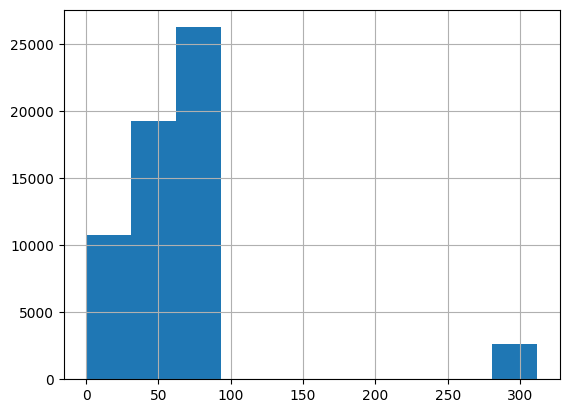

In [ ]:
df_adm['age'].hist()

## ICU dataset

In [ ]:
df_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [ ]:
df_icu.groupby('FIRST_CAREUNIT').median(numeric_only=True)

ROW_ID  SUBJECT_ID   HADM_ID  ICUSTAY_ID  FIRST_WARDID  \
FIRST_CAREUNIT                                                            
CCU             29091.5     22964.5  150074.5    249373.5           7.0   
CSRU            31002.5     24488.0  150225.0    250492.0          14.0   
MICU            33612.5     26489.5  150368.0    250524.0          50.0   
NICU            19581.5     15456.5  149206.5    249308.0          56.0   
SICU            38089.0     30084.0  149744.0    248649.0          33.0   
TSICU           36382.0     28716.0  148915.0    250685.0          14.0   

                LAST_WARDID      LOS  
FIRST_CAREUNIT                        
CCU                     7.0  2.19775  
CSRU                   14.0  2.15290  
MICU                   50.0  2.09550  
NICU                   56.0  0.80250  
SICU                   33.0  2.25220  
TSICU                  14.0  2.11150

In [ ]:
# Based on above statistics, reduce to just ICU and NICU groups
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [ ]:
df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

HADM_ID    cat
0   100001  [ICU]
1   100003  [ICU]
2   100006  [ICU]
3   100007  [ICU]
4   100009  [ICU]

In [ ]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item = icu_item.merge(df_icu[["HADM_ID", "LOS"]], on="HADM_ID")
icu_item.head()

ICU  NICU  HADM_ID     LOS
0    1     0   100001  4.2567
1    1     0   100003  1.9425
2    1     0   100006  4.9776
3    1     0   100007  4.0998
4    1     0   100009  2.4908

In [ ]:
icu_item.rename(columns={"LOS": "ICU_LOS"}, inplace=True)

In [ ]:
icu_item.describe()

ICU          NICU        HADM_ID       ICU_LOS
count  61532.000000  61532.000000   61532.000000  61522.000000
mean       0.868361      0.131639  149954.470649      4.917972
std        0.338100      0.338100   28898.895904      9.638784
min        0.000000      0.000000  100001.000000      0.000100
25%        1.000000      0.000000  124933.750000      1.108025
50%        1.000000      0.000000  149911.500000      2.092250
75%        1.000000      0.000000  174997.250000      4.483175
max        1.000000      1.000000  199999.000000    173.072500

In [ ]:
# Merge ICU data with main dataFrame
df_adm = df_adm.merge(icu_item, how='outer', on='HADM_ID')

## Cleaning

In [ ]:
# Replace NaNs with 0
df_adm['ICU'].fillna(value=0, inplace=True)
df_adm['NICU'].fillna(value=0, inplace=True)

In [ ]:
# Remove deceased persons as they will skew LOS result
# df_adm = df_adm[df_adm['DECEASED'] == 0]

# Remove LOS with negative number, likely entry form error
df_adm = df_adm[df_adm['LOS'] > 0]

In [ ]:
# Truncating age to 90 if age = 300
df_adm["age"] = df_adm["age"].apply(lambda x: 90 if x >= 300 else x)

In [ ]:
# Recoding gender
df_adm["GENDER"] = df_adm["GENDER"] == "M"

In [ ]:
df_adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
       'NEXT_ADMISSION_TYPE', 'DAYS_NEXT_ADMIT', 'LOS', 'blood', 'circulatory',
       'congenital', 'digestive', 'endocrine', 'genitourinary', 'infectious',
       'injury', 'mental', 'misc', 'muscular', 'neoplasms', 'nervous',
       'pregnancy', 'prenatal', 'respiratory', 'skin', 'DOB', 'GENDER', 'age',
       'ICU', 'NICU', 'DECEASED'],
      dtype='object')

### Readmission

In [ ]:
data_analysis = df_adm.copy(deep=True)

In [ ]:
# Remove patients who aged less than 18
data_analysis = data_analysis[(data_analysis["age"] >= 18) & (data_analysis["age"] < 90)]

In [ ]:
data_analysis[["ADMISSION_TYPE"]].value_counts()

ADMISSION_TYPE
EMERGENCY         42210
ELECTIVE           7979
URGENT             1375
Name: count, dtype: int64

In [ ]:
# verify that it did what we wanted
data_analysis[['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','DISCHTIME','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE', 'DAYS_NEXT_ADMIT']].head()

SUBJECT_ID           ADMITTIME ADMISSION_TYPE           DISCHTIME  \
1            3 2101-10-20 19:08:00      EMERGENCY 2101-10-31 13:58:00   
2            4 2191-03-16 00:28:00      EMERGENCY 2191-03-23 18:41:00   
4            6 2175-05-30 07:15:00       ELECTIVE 2175-06-15 16:00:00   
8            9 2149-11-09 13:06:00      EMERGENCY 2149-11-14 10:15:00   
10          11 2178-04-16 06:18:00      EMERGENCY 2178-05-11 19:00:00   

   NEXT_ADMITTIME NEXT_ADMISSION_TYPE  DAYS_NEXT_ADMIT  
1             NaT                 NaN              NaN  
2             NaT                 NaN              NaN  
4             NaT                 NaN              NaN  
8             NaT                 NaN              NaN  
10            NaT                 NaN              NaN

In [ ]:
data_analysis.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
       'NEXT_ADMISSION_TYPE', 'DAYS_NEXT_ADMIT', 'LOS', 'DECEASED', 'blood',
       'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary',
       'infectious', 'injury', 'mental', 'muscular', 'neoplasms', 'nervous',
       'pregnancy', 'prenatal', 'respiratory', 'skin', 'supp1', 'supp2',
       'symtoms_signs', 'DOB', 'GENDER', 'age', 'ICU', 'NICU', 'ICU_LOS'],
      dtype='object')

In [ ]:
# 30-day readmission
data_analysis["Readmission"] = data_analysis["DAYS_NEXT_ADMIT"] <=30

In [ ]:
data_analysis["Readmission"].value_counts()

Readmission
False    48442
True      3122
Name: count, dtype: int64

In [ ]:
# Selecting unique patients for those who had readmission
data_analysis_Readmission_Row_id = data_analysis[data_analysis["Readmission"] == 1].groupby(["SUBJECT_ID"])["ROW_ID"].agg(lambda x: np.random.choice(list(x))).reset_index()

data_ML = pd.concat(
    [
        data_analysis[data_analysis["ROW_ID"].isin(data_analysis_Readmission_Row_id["ROW_ID"])].copy(),
        data_analysis[~data_analysis["SUBJECT_ID"].isin(data_analysis[data_analysis["Readmission"] == 1]["SUBJECT_ID"])].copy()
    ]
)

In [ ]:
data_ML["Readmission"].value_counts()

Readmission
False    43567
True      2403
Name: count, dtype: int64

In [ ]:
# Drop unused or no longer needed columns
data_ML.drop(columns=['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'DOB', 'DISCHTIME',
                'DIAGNOSIS', 'DECEASED',  'DEATHTIME', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
                            'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
                            'NEXT_ADMISSION_TYPE', 'DAYS_NEXT_ADMIT',
                            "RELIGION"
                            ], inplace=True)

data_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45969 entries, 36 to 62721
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ADMISSION_TYPE  45969 non-null  object 
 1   INSURANCE       45969 non-null  object 
 2   MARITAL_STATUS  45969 non-null  object 
 3   ETHNICITY       45969 non-null  object 
 4   LOS             45969 non-null  float64
 5   blood           45969 non-null  bool   
 6   circulatory     45969 non-null  bool   
 7   congenital      45969 non-null  bool   
 8   digestive       45969 non-null  bool   
 9   endocrine       45969 non-null  bool   
 10  genitourinary   45969 non-null  bool   
 11  infectious      45969 non-null  bool   
 12  injury          45969 non-null  bool   
 13  mental          45969 non-null  bool   
 14  muscular        45969 non-null  bool   
 15  neoplasms       45969 non-null  bool   
 16  nervous         45969 non-null  bool   
 17  pregnancy       45969 non-null  boo

## Descriptive analysis

In [ ]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'ETH', 'MAR']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE',
              'ETHNICITY', 'MARITAL_STATUS']
data_ML = pd.get_dummies(data_ML, prefix=prefix_cols, columns=dummy_cols)
data_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45969 entries, 36 to 62721
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LOS                         45969 non-null  float64
 1   blood                       45969 non-null  bool   
 2   circulatory                 45969 non-null  bool   
 3   congenital                  45969 non-null  bool   
 4   digestive                   45969 non-null  bool   
 5   endocrine                   45969 non-null  bool   
 6   genitourinary               45969 non-null  bool   
 7   infectious                  45969 non-null  bool   
 8   injury                      45969 non-null  bool   
 9   mental                      45969 non-null  bool   
 10  muscular                    45969 non-null  bool   
 11  neoplasms                   45969 non-null  bool   
 12  nervous                     45969 non-null  bool   
 13  pregnancy                   45969 n

In [ ]:
from collections import OrderedDict
EDA_Table_1 = OrderedDict()
for c in [col for col in data_ML.columns if col != "Readmission"]:
  if c in ["LOS", "age", "ICU_LOS"]:
    EDA_Table_1[c] = lambda x: x.mean()
  else:
    EDA_Table_1[c] = lambda x: x.mean() * 100
Display_Table_1 = data_ML.groupby("Readmission").agg(EDA_Table_1)
Display_Table_1.T

Readmission                     False      True 
LOS                         10.957962  14.800205
blood                       37.291987  46.169858
circulatory                 82.617578  88.634471
congenital                   3.539376   3.788510
digestive                   40.374595  48.542881
endocrine                   68.884706  74.979184
genitourinary               40.606422  53.247294
infectious                  27.295889  37.385512
injury                      45.571189  49.833472
mental                      31.718962  33.014155
muscular                    18.979962  21.815154
neoplasms                   18.502536  19.400500
nervous                     29.960750  35.220649
pregnancy                    0.374136   0.124896
prenatal                     0.002295   0.000000
respiratory                 49.009571  59.575354
skin                        11.143756  15.820150
supp1                       49.454863  59.950042
supp2                       33.339454  34.679434
symtoms_signs               38.800009  45.503747
GENDER                      57.476989  57.618651
age                         62.708612  64.461930
ICU                         98.168338  97.127394
NICU                         0.000000   0.000000
ICU_LOS                      4.026796   6.020549
ADM_ELECTIVE                17.070260  12.156536
ADM_EMERGENCY               80.140932  85.678601
ADM_URGENT                   2.788808   2.164863
INS_Government               3.011454   1.998335
INS_Medicaid                 8.706131   9.700250
INS_Medicare                52.454840  60.324729
INS_Private                 34.572038  27.393838
INS_Self Pay                 1.255537   0.582848
ETH_ASIAN                    2.391719   2.081599
ETH_BLACK/AFRICAN AMERICAN   8.226410  12.239800
ETH_HISPANIC/LATINO          3.394771   3.913405
ETH_OTHER/UNKNOWN           14.575252   7.868443
ETH_WHITE                   71.411848  73.896753
MAR_MARRIED                 49.493883  48.459617
MAR_SINGLE                  25.147474  26.727727
MAR_UNKNOWN (DEFAULT)        5.811738   2.456286
MAR_WDS                     19.546905  22.356370

There are several varibles do not have any or really small values, for example "pregnancy", "prenatal", "NICU", "INS_Self Pay", "ADM_URGENT" that could infect the prediction models. Therefore, "prenatal" and "NICU" will be excluded from the predicted variables.

In [ ]:
data_ML.drop(columns=["NICU", "pregnancy", "prenatal"], inplace=True)

# Machine learning

In [ ]:
from sklearn.model_selection import train_test_split

X = data_ML[[c for c in data_ML.columns if c != "Readmission"]]
y = data_ML["Readmission"]
# to investigate the fairness of ML model
gender = data_ML[[c for c in data_ML if "GENDER" in c]]

# using stratified split because the imbalanced data
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, gender, test_size = 0.3, random_state=42, stratify=y)

In [ ]:
IR_count = np.bincount(y_train)
IR = IR_count[1] / IR_count[0]

In [ ]:
1/IR

18.13139120095125

In [110]:
from sklearn.model_selection import cross_val_predict
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)

import sklearn.metrics

import optuna

# 1. Define an objective function to be maximized.
def objective(trial):
    ...

    # cost-sensitive learning
    IR_count = np.bincount(y_train)
    IR = IR_count[1] / IR_count[0]

    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1, log=True),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_pre_filter': False,
        "scale_pos_weight": trial.suggest_float('scale_pos_weight', (1 / IR) * 0.5, (1 / IR) * 1.2, log=True)
    }

    gbm = lgb.LGBMClassifier(**param).fit(X_train, y_train)
    gbm_predicted_proba = cross_val_predict(gbm, X_train, y_train, cv=10, method='predict_proba')[:, 1]
    ...
    # return sklearn.metrics.accuracy_score(y_train, np.rint(gbm_predicted_proba))
    return sklearn.metrics.roc_auc_score(y_train, gbm_predicted_proba)

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-04-21 20:50:28,802] A new study created in memory with name: no-name-ce8dd149-337b-4b3a-b8e2-167af62b99fe
[I 2024-04-21 20:50:45,305] Trial 0 finished with value: 0.6344019326697898 and parameters: {'learning_rate': 4.613964830206501e-06, 'lambda_l1': 2.414873402873824, 'lambda_l2': 0.5485226852649198, 'num_leaves': 64, 'feature_fraction': 0.9933581281293122, 'bagging_fraction': 0.9337653121177499, 'bagging_freq': 2, 'min_child_samples': 28, 'scale_pos_weight': 9.705690463679746}. Best is trial 0 with value: 0.6344019326697898.
[I 2024-04-21 20:51:02,709] Trial 1 finished with value: 0.6033236863566827 and parameters: {'learning_rate': 8.250564768102558e-08, 'lambda_l1': 0.024757320988866464, 'lambda_l2': 1.8054102758007577, 'num_leaves': 256, 'feature_fraction': 0.7497129342937083, 'bagging_fraction': 0.6803430714107435, 'bagging_freq': 2, 'min_child_samples': 9, 'scale_pos_weight': 12.011112086544856}. Best is trial 0 with value: 0.6344019326697898.
[I 2024-04-21 20:51:09,477

In [111]:
optuna.visualization.plot_slice(study)

In [112]:
lgb_model = lgb.LGBMClassifier(**study.best_params).fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.617040895044662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.617040895044662
[LightGBM] [Warning] lambda_l2 is set=0.021163294894888628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021163294894888628
[LightGBM] [Warning] lambda_l1 is set=0.007044183034851629, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007044183034851629
[LightGBM] [Warning] bagging_fraction is set=0.8255671266891416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8255671266891416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.617040895044662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.617040895044662
[LightGBM] [Warning] lambda_l2 is set=0.021163294894888628, reg_lambda=0.0 will be ign

In [113]:
import joblib
# save model
joblib.dump(lgb_model, 'lgb.pkl')

['lgb.pkl']

In [121]:
pd.concat([X_train, y_train]).to_csv("Training_Data.csv")
pd.concat([X_test, y_test]).to_csv("Testing_Data.csv")

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

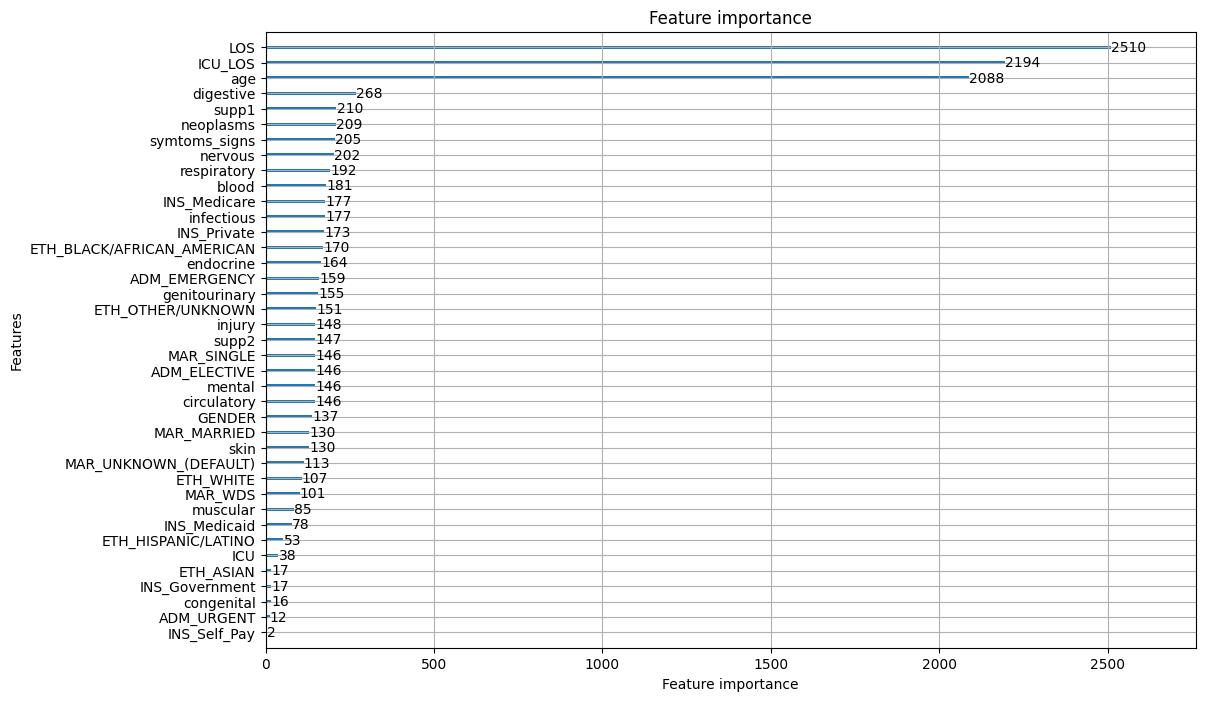

In [114]:
lgb.plot_importance(lgb_model, figsize=(12, 8))

In [115]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

[LightGBM] [Warning] feature_fraction is set=0.617040895044662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.617040895044662
[LightGBM] [Warning] lambda_l2 is set=0.021163294894888628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021163294894888628
[LightGBM] [Warning] lambda_l1 is set=0.007044183034851629, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007044183034851629
[LightGBM] [Warning] bagging_fraction is set=0.8255671266891416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8255671266891416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.617040895044662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.617040895044662
[LightGBM] [Warning] lambda_l2 is set=0.021163294894888628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021163294894888628
[LightGBM] [Warning] lambda_

<ipython-input-115-44302ee44df6>:11: RuntimeWarning:

invalid value encountered in scalar divide



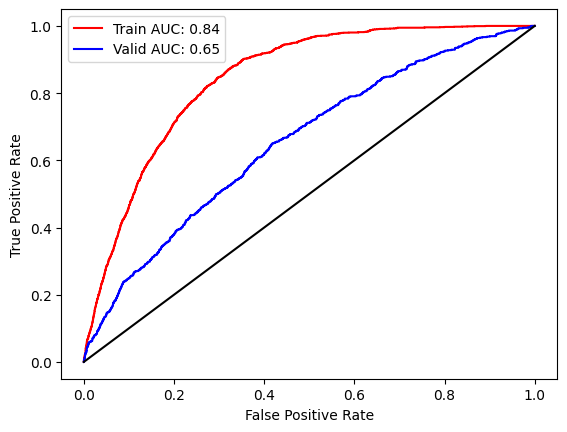

In [116]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_train_preds = lgb_model.predict_proba(X_train)[:, 1]
y_valid_preds = lgb_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_test, y_valid_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_test, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_test, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_test, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_test, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_test, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_test))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [82]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.1 MB/s eta 0:00:00


In [117]:
import shap
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer(X_train)

In [118]:
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values.values[1, :], X_train.iloc[0, :]
)

In [119]:
shap.initjs()
random_index = np.random.randint(0, shap_values.shape[0]-1, 1000)
shap.force_plot(
    explainer.expected_value, shap_values.values[random_index, :], X_train.iloc[random_index, :]
)

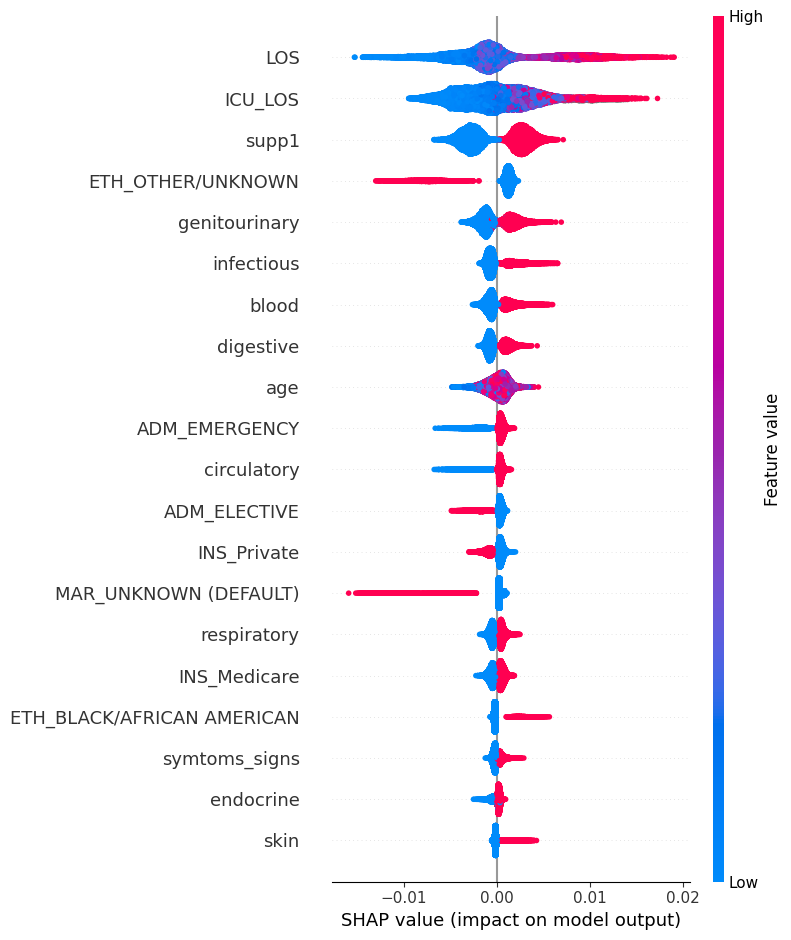

In [120]:
shap.initjs()
shap.summary_plot(shap_values, X_train)